In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차를 사용하여 정규화
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# 신경망 정의
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            torch.nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # 데이터를 디바이스로 이동
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

model = SimpleNN()

learning_rate = 1e-2
batch_size = 64

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

num_epochs = 4

time=[]
loss_value=[]
j=0

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            j+=1
            time.append(j)
            loss_value.append(running_loss/100)
            running_loss = 0.0
            
test_loop(testloader, model, criterion)
print("Finished Training")

# 모델 저장
torch.save(model.state_dict(), 'mnist_simple_nn.pth')


cuda:0
[Epoch 1, Batch 100] Loss: 0.488
[Epoch 1, Batch 200] Loss: 0.274
[Epoch 1, Batch 300] Loss: 0.226
[Epoch 1, Batch 400] Loss: 0.195
[Epoch 1, Batch 500] Loss: 0.187
[Epoch 1, Batch 600] Loss: 0.191
[Epoch 1, Batch 700] Loss: 0.153
[Epoch 1, Batch 800] Loss: 0.146
[Epoch 1, Batch 900] Loss: 0.159
[Epoch 2, Batch 100] Loss: 0.120
[Epoch 2, Batch 200] Loss: 0.112
[Epoch 2, Batch 300] Loss: 0.110
[Epoch 2, Batch 400] Loss: 0.130
[Epoch 2, Batch 500] Loss: 0.118
[Epoch 2, Batch 600] Loss: 0.118
[Epoch 2, Batch 700] Loss: 0.104
[Epoch 2, Batch 800] Loss: 0.108
[Epoch 2, Batch 900] Loss: 0.113
[Epoch 3, Batch 100] Loss: 0.082
[Epoch 3, Batch 200] Loss: 0.086
[Epoch 3, Batch 300] Loss: 0.089
[Epoch 3, Batch 400] Loss: 0.081
[Epoch 3, Batch 500] Loss: 0.088
[Epoch 3, Batch 600] Loss: 0.105
[Epoch 3, Batch 700] Loss: 0.096
[Epoch 3, Batch 800] Loss: 0.105
[Epoch 3, Batch 900] Loss: 0.096
[Epoch 4, Batch 100] Loss: 0.066
[Epoch 4, Batch 200] Loss: 0.072
[Epoch 4, Batch 300] Loss: 0.074
[Ep

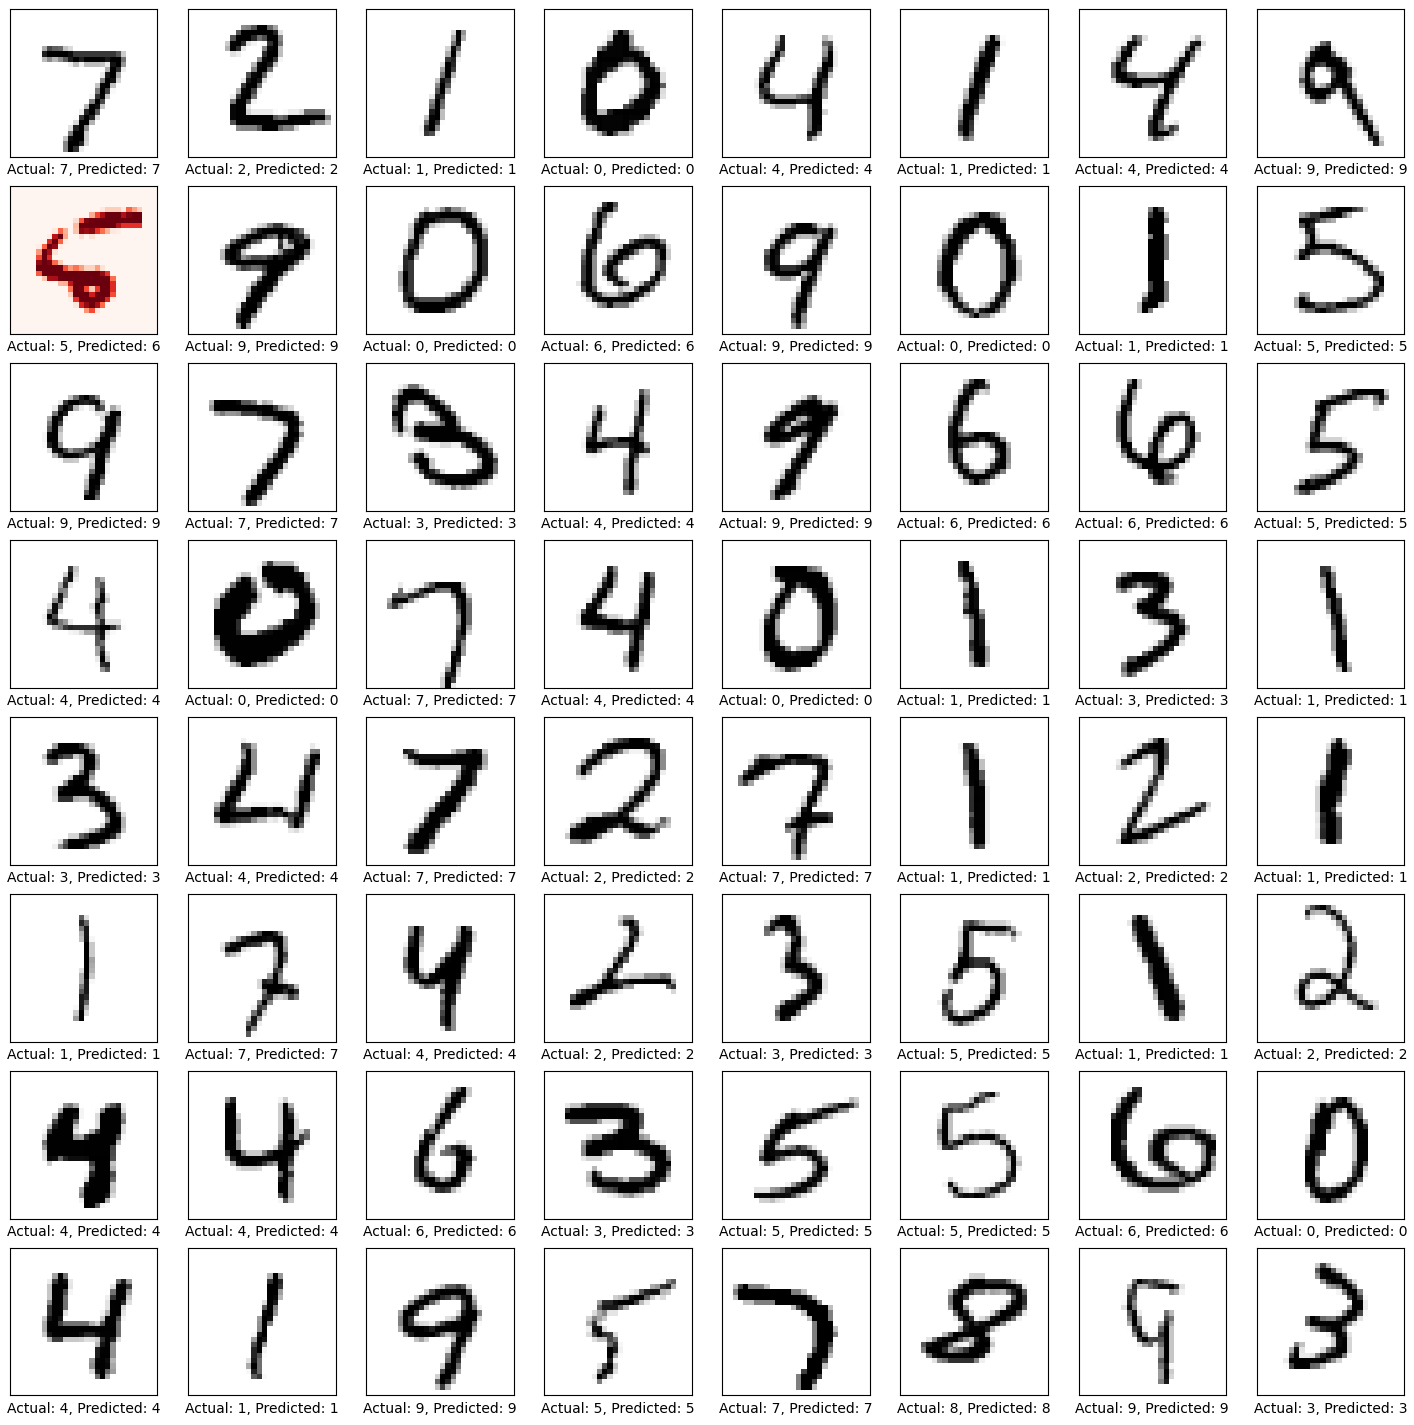

In [14]:
import matplotlib.pyplot as plt
import math

# 학습 완료 후 테스트 데이터로 예측 수행
model.eval()
test_images, test_labels = next(iter(testloader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
with torch.no_grad():
    test_outputs = model(test_images)
softmax = nn.Softmax(dim=1)
probabilities = softmax(test_outputs)
predicted_classes = torch.argmax(probabilities, dim=1)

error=[]


# 이미지 및 예측 시각화
plt.figure(figsize=(18, 18))
for i in range(len(test_labels)):
    plt.subplot(int(math.sqrt(len(test_labels))), int(math.sqrt(len(test_labels))), i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if test_labels[i]!=predicted_classes[i]:
        error.append(i)
        cmap = 'Reds'
    else:
        cmap = plt.cm.binary
    plt.imshow(test_images[i].cpu().numpy().squeeze(), cmap=cmap)
    plt.xlabel(f'Actual: {test_labels[i]}, Predicted: {predicted_classes[i]}')
plt.show()


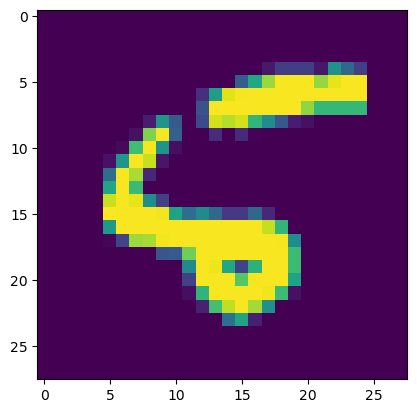

actual: 5, predicted: 6, index: 8


In [12]:
for i in range(len(error)):
    plt.imshow(testset[error[i]][0].cpu().numpy().squeeze())
    plt.show()
    print(f"actual: {testset[error[i]][1]}, predicted: {predicted_classes[error[i]]}, index: {error[i]}")

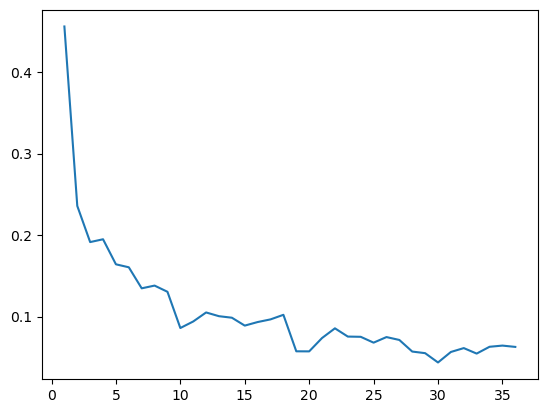

In [15]:
plt.plot(time,loss_value)